In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
from google.colab import files

print("Please upload 'student-mat.csv' and 'student-por.csv'")
files.upload()

Please upload 'student-mat.csv' and 'student-por.csv'


Saving student_visual.csv to student_visual.csv


{'student_visual.csv': b'school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian_x,traveltime_x,studytime_x,failures_x,schoolsup_x,famsup_x,paid_x,activities_x,nursery,higher_x,internet,romantic_x,famrel_x,freetime_x,goout_x,Dalc_x,Walc_x,health_x,absences_x,G1_x,G2_x,G3_x,guardian_y,traveltime_y,studytime_y,failures_y,schoolsup_y,famsup_y,paid_y,activities_y,higher_y,romantic_y,famrel_y,freetime_y,goout_y,Dalc_y,Walc_y,health_y,absences_y,G1_y,G2_y,G3_y,at_risk_math,at_risk_port,at_risk_total,total_absences,total_failures,mean_parent_edu,avg_study_time,family_support,avg_alcohol_consumption,internet_access,urban_rural,school_support\nGP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6.0,5,6,6,mother,2,2,0,yes,no,no,no,yes,no,4,3,4,1,1,3,4,0,11,11,1,0,At Risk (Math Only),10.0,0,4.0,2.0,0,1.0,0,1,1\nGP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4.0,5,5,6,father,1,2,0,no,yes,no,

In [3]:
df_ = pd.read_csv('student_visual.csv')
all_columns = df_.columns
numeric_cols = df_.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = all_columns.difference(numeric_cols)


In [4]:
df = df_.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
print(df.head())

   school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  ...  \
0       0    0   18        1        0        0     4     4     0     3  ...   
1       0    0   17        1        0        1     1     1     0     1  ...   
2       0    0   15        1        1        1     1     1     0     1  ...   
3       0    0   15        1        0        1     4     2     1     2  ...   
4       0    0   16        1        0        1     3     3     2     1  ...   

   at_risk_total  total_absences  total_failures  mean_parent_edu  \
0              1            10.0               0              4.0   
1              1             6.0               0              1.0   
2              3            16.0               3              1.0   
3              3             2.0               0              3.0   
4              3             4.0               0              3.0   

   avg_study_time  family_support  avg_alcohol_consumption  internet_access  \
0             2.0              

In [5]:
exclude = ['G1_x', 'G2_x', 'G1_y', 'G2_y',
    'G3_x',
    'G3_y',
    'failures_x',
    'failures_y','absences_x', 'dalc_x', 'Walc_x', 'health_x',
    'freetime_x', 'family_support', 'internet_access','total_failures',
    'at_risk_math',   # Target variable for math
    'at_risk_port',   # Target variable for portuguese
    'at_risk_total'   # Target variable for overall
]
all_features = [col for col in df.columns if col not in exclude]
feature_cols = [col for col in all_features ]

#choose the target
X = df[feature_cols]
Y = df[['at_risk_math', 'at_risk_port', 'at_risk_total']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
# Multi-target RF
rf = MultiOutputClassifier(RandomForestClassifier(random_state=42))
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [7]:
print("MODEL EVALUATION - RF CLASSIFICATION METRICS FOR EACH OUTPUT:")
target_cols = Y.columns
for i, col in enumerate(target_cols):
    print(f"\n--- Metrics for {col} ---")
    y_true_col = y_test.iloc[:, i]
    y_pred_col = y_pred[:, i]

    # Check if it's binary or multi-class to set the `average` parameter for metrics
    unique_classes = np.unique(y_true_col)
    if len(unique_classes) <= 2: # Assuming binary for 2 unique classes or less (0, 1)
        average_type = 'binary'
    else: # Multi-class
        average_type = 'weighted' # 'weighted' accounts for class imbalance

    accuracy = accuracy_score(y_true_col, y_pred_col)
    precision = precision_score(y_true_col, y_pred_col, average=average_type, zero_division=0)
    recall = recall_score(y_true_col, y_pred_col, average=average_type, zero_division=0)
    f1 = f1_score(y_true_col, y_pred_col, average=average_type, zero_division=0)

    print(f"Accuracy:  {accuracy:.3f} ({accuracy*100:.1f}%) -- Overall correctness")
    print(f"Precision: {precision:.3f} -- Of flagged students, how many were truly at-risk (for this category)")
    print(f"Recall:    {recall:.3f} -- How many at-risk students were caught (for this category)")
    print(f"F1-Score:  {f1:.3f} -- Harmonic mean of precision and recall")

MODEL EVALUATION - RF CLASSIFICATION METRICS FOR EACH OUTPUT:

--- Metrics for at_risk_math ---
Accuracy:  0.662 (66.2%) -- Overall correctness
Precision: 0.333 -- Of flagged students, how many were truly at-risk (for this category)
Recall:    0.083 -- How many at-risk students were caught (for this category)
F1-Score:  0.133 -- Harmonic mean of precision and recall

--- Metrics for at_risk_port ---
Accuracy:  0.883 (88.3%) -- Overall correctness
Precision: 0.000 -- Of flagged students, how many were truly at-risk (for this category)
Recall:    0.000 -- How many at-risk students were caught (for this category)
F1-Score:  0.000 -- Harmonic mean of precision and recall

--- Metrics for at_risk_total ---
Accuracy:  0.675 (67.5%) -- Overall correctness
Precision: 0.595 -- Of flagged students, how many were truly at-risk (for this category)
Recall:    0.675 -- How many at-risk students were caught (for this category)
F1-Score:  0.593 -- Harmonic mean of precision and recall



--- Confusion Matrix for at_risk_math ---


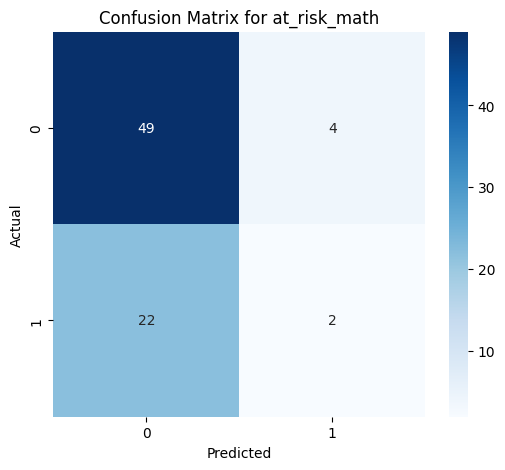


--- Confusion Matrix for at_risk_port ---


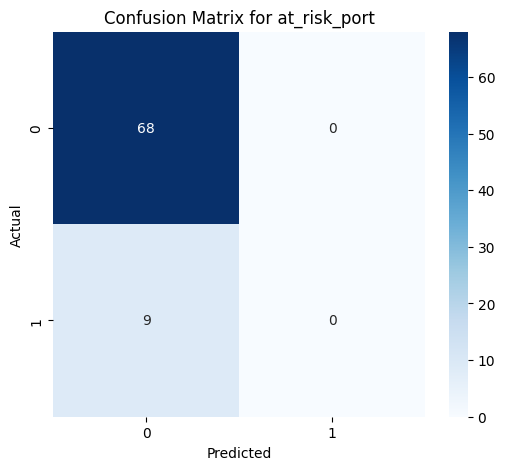


--- Confusion Matrix for at_risk_total ---


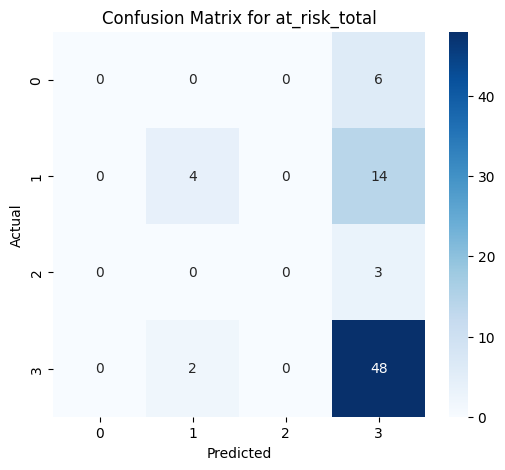

In [8]:
# Generate confusion matrix for each output
target_cols = Y.columns
for i, col in enumerate(target_cols):
    print(f"\n--- Confusion Matrix for {col} ---")
    y_true_col = y_test.iloc[:, i]
    y_pred_col = y_pred[:, i]

    cm = confusion_matrix(y_true_col, y_pred_col)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {col}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
# Multi-target knn
# Create KNN model (can change k)
knn = KNeighborsClassifier(n_neighbors=5)


knn_multi = MultiOutputClassifier(knn)

# Train
knn_multi.fit(X_train, y_train)

# Predict
y_pred_knn = knn_multi.predict(X_test)

In [11]:
print("MODEL EVALUATION - KNN CLASSIFICATION METRICS FOR EACH OUTPUT:")
target_cols = Y.columns
for i, col in enumerate(target_cols):
    print(f"\n--- Metrics for {col} ---")
    y_true_col = y_test.iloc[:, i]
    y_pred_col = y_pred_knn[:, i]

    # Check if it's binary or multi-class to set the `average` parameter for metrics
    unique_classes = np.unique(y_true_col)
    if len(unique_classes) <= 2: # Assuming binary for 2 unique classes or less (0, 1)
        average_type = 'binary'
    else: # Multi-class
        average_type = 'weighted' # 'weighted' accounts for class imbalance

    accuracy = accuracy_score(y_true_col, y_pred_col)
    precision = precision_score(y_true_col, y_pred_col, average=average_type, zero_division=0)
    recall = recall_score(y_true_col, y_pred_col, average=average_type, zero_division=0)
    f1 = f1_score(y_true_col, y_pred_col, average=average_type, zero_division=0)

    print(f"Accuracy:  {accuracy:.3f} ({accuracy*100:.1f}%) -- Overall correctness")
    print(f"Precision: {precision:.3f} -- Of flagged students, how many were truly at-risk (for this category)")
    print(f"Recall:    {recall:.3f} -- How many at-risk students were caught (for this category)")
    print(f"F1-Score:  {f1:.3f} -- Harmonic mean of precision and recall")

MODEL EVALUATION - KNN CLASSIFICATION METRICS FOR EACH OUTPUT:

--- Metrics for at_risk_math ---
Accuracy:  0.701 (70.1%) -- Overall correctness
Precision: 0.600 -- Of flagged students, how many were truly at-risk (for this category)
Recall:    0.125 -- How many at-risk students were caught (for this category)
F1-Score:  0.207 -- Harmonic mean of precision and recall

--- Metrics for at_risk_port ---
Accuracy:  0.883 (88.3%) -- Overall correctness
Precision: 0.000 -- Of flagged students, how many were truly at-risk (for this category)
Recall:    0.000 -- How many at-risk students were caught (for this category)
F1-Score:  0.000 -- Harmonic mean of precision and recall

--- Metrics for at_risk_total ---
Accuracy:  0.649 (64.9%) -- Overall correctness
Precision: 0.512 -- Of flagged students, how many were truly at-risk (for this category)
Recall:    0.649 -- How many at-risk students were caught (for this category)
F1-Score:  0.557 -- Harmonic mean of precision and recall



--- Confusion Matrix for at_risk_math ---


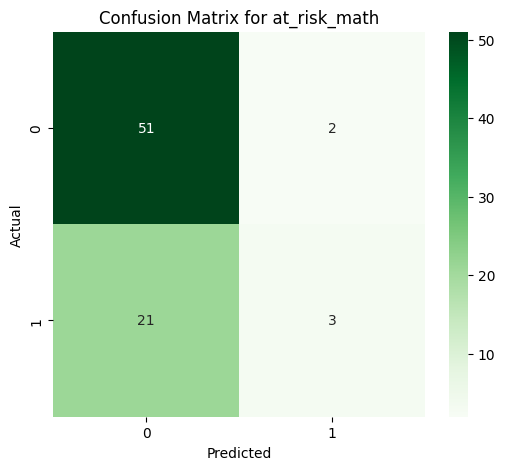


--- Confusion Matrix for at_risk_port ---


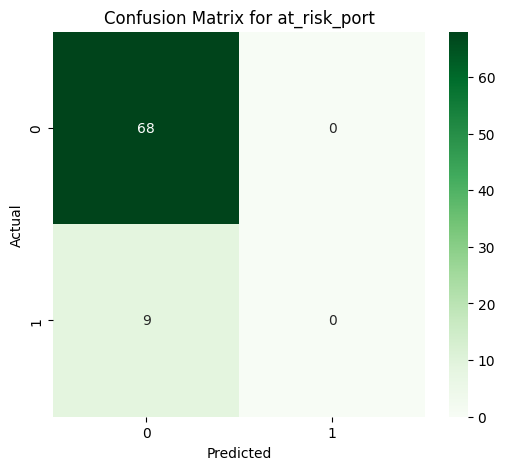


--- Confusion Matrix for at_risk_total ---


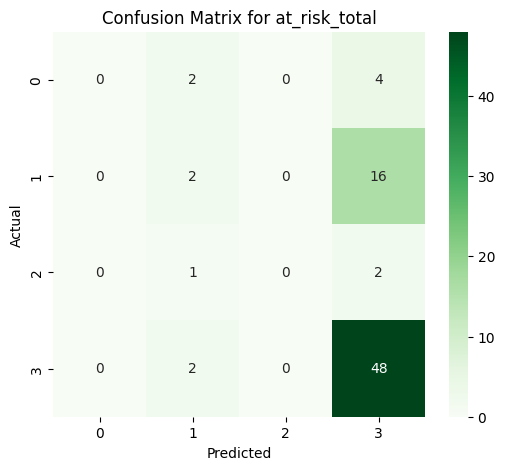

In [12]:
target_cols = Y.columns
for i, col in enumerate(target_cols):
    print(f"\n--- Confusion Matrix for {col} ---")
    y_true_col = y_test.iloc[:, i]
    y_pred_col = y_pred_knn[:, i]

    cm = confusion_matrix(y_true_col, y_pred_col)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f"Confusion Matrix for {col}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

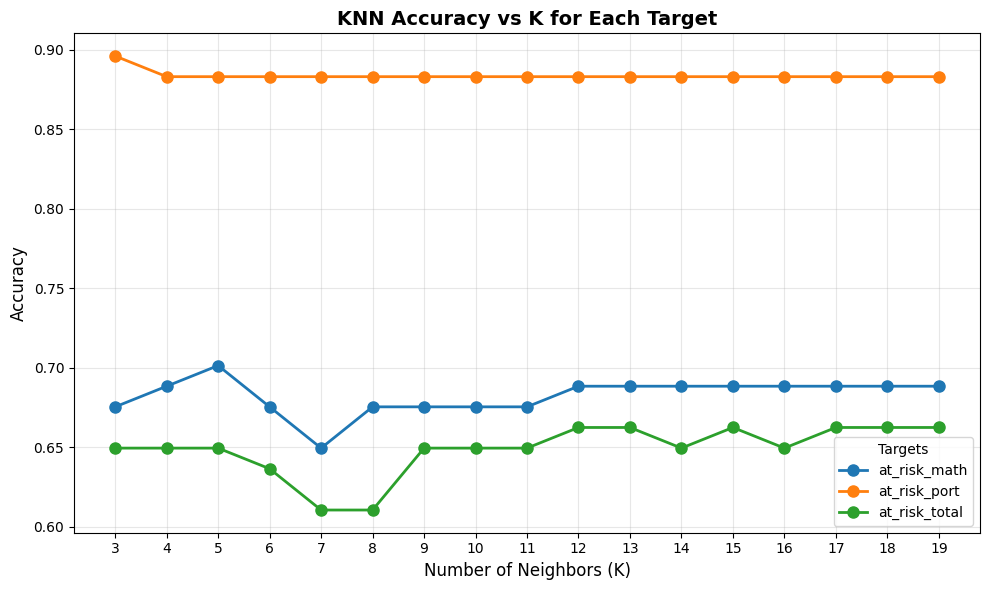

In [15]:
k_values = range(3, 20)

target_cols = Y.columns
knn_scores = {col: [] for col in target_cols}

for k in k_values:
    knn = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=k))
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)

    # Compute accuracy for each output column
    for i, col in enumerate(target_cols):
        y_true_col = y_test.iloc[:, i]
        y_pred_col = y_pred_knn[:, i]
        acc = accuracy_score(y_true_col, y_pred_col)

        knn_scores[col].append(acc)
plt.figure(figsize=(10, 6))

for col in target_cols:
    plt.plot(k_values, knn_scores[col], marker='o', linewidth=2, markersize=8, label=col)

plt.xlabel('Number of Neighbors (K)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('KNN Accuracy vs K for Each Target', fontsize=14, fontweight='bold')
plt.xticks(k_values)
plt.grid(alpha=0.3)
plt.legend(title="Targets")
plt.tight_layout()
plt.show()